In [1]:
import numpy as np 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import control.matlab as control_
import control
import math 
from sympy import symbols, solve

def pos(lst):
    return [x for x in lst if x > 0] or None

pi=math.pi
X= symbols('x')
#Assigning some constants 
Fref=96e6
Tref=1/Fref
Fo=5e9
N=Fo/Fref
KVCO=150e6*2*pi
BW=2*pi*1e6
PM=(70/180)*pi
delta=1e-12
A=(((BW)**2)*2*pi*delta*N)/(KVCO*math.sqrt(1+(math.tan(PM)**2)))
B=(math.tan(PM)*Fref*BW*2*pi*delta*N)/(KVCO*(math.sqrt(1+(math.tan(PM)**2))))

In [2]:
A

4.688338210872546e-06

In [3]:
B

0.00019680876227290322

In [4]:
# TDC noise specturm 
T_TDC=(4*(pi**2)*(delta**2))/(12*Tref)

In [5]:
#VCO phase noise 
w=np.linspace(2*pi*1,2*pi*20e9,500000)
T_osc=control.tf([1,2*pi*10e4],[1,0])
T_osc=T_osc*30
s=control.tf([1],[1,0,0])
T_osc=T_osc*s
T_osc

TransferFunction(array([3.00000000e+01, 1.88495559e+07]), array([1, 0, 0, 0]))

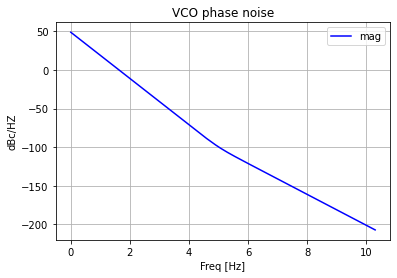

In [6]:
#VCO phase noise 
(mag, phase_rad, w) = control.bode(T_osc, w,dB=True,Hz=True,plot=False)
'''for i in range(np.shape(w)[0]):
    if 10*np.log10(mag[i]) <= -125 :
        mag[i:]=mag[i]
        break'''
plt.plot(np.log10(w/(2*pi)), 10*np.log10(mag), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('VCO phase noise')
plt.grid() 
plt.legend(labels=('mag',))

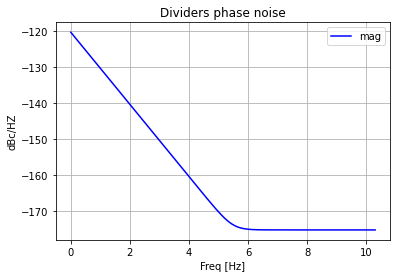

In [7]:
# Divider transfer phase noise 
T_Divider=control.tf([1,2*300e3*pi],[1,0])
T_Divider=T_Divider*3.01506e-18

(mag_Divider, phase_rad_Divider, w) = control.bode(T_Divider, w,dB=True,Hz=True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(mag_Divider), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('Dividers phase noise')
plt.grid() 
plt.legend(labels=('mag',))

In [8]:
#Reference phase noise 
T_ref=control.tf([1,1e3*2*pi],[1,0])
T_ref_1=control.tf([1,1e4*pi],[1])
T_ref_2=control.tf([1,1e7*2*pi],[1])
T_ref=T_ref*(2.224970786e-19)*T_ref_1*T_ref_2
s=control.tf([1],[1,0,0])
T_ref=T_ref*s
T_ref

TransferFunction(array([2.22497079e-19, 1.39882917e-11, 5.27073874e-07, 2.75952239e-03]), array([1, 0, 0, 0]))

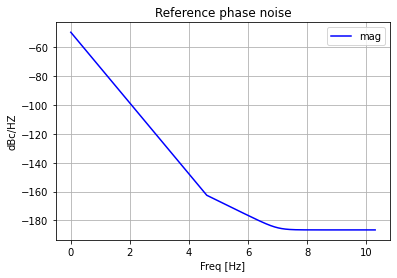

In [9]:
#Reference phase noise 
(mag_ref, phase_rad_ref, w) = control.bode(T_ref, w,dB=True,Hz=True,plot=False)
for i in range(np.shape(w)[0]):
    if 10*np.log10(mag_ref[i]) <= -220 :
        mag_ref[i:]=mag_ref[i]
        break 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(mag_ref), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('Reference phase noise')
plt.grid() 
plt.legend(labels=('mag',))

In [10]:
# # Feedback of the loop in the middle 
# #Closed loop 
# Bs_=(Ts)/(1+(Ts))
# (mag_FB, phase_rad_FB, w) = control.bode_plot(Bs, w,dB=True, deg= True )

TransferFunction(array([1.93216551e-03, 4.41865466e+03]), array([3.27249235e-10, 0.00000000e+00, 0.00000000e+00]))

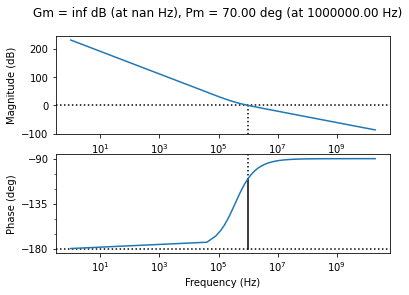

In [11]:
# open gain for Feedback loop 
Ts=control.tf([B*Tref,A],[2*pi*N*delta,0,0])
Ts=Ts*KVCO
(mag_Feed, phase_rad_Feed, w) = control.bode_plot(Ts, w,dB=True, deg= True ,Hz=True, margins=True)
Ts

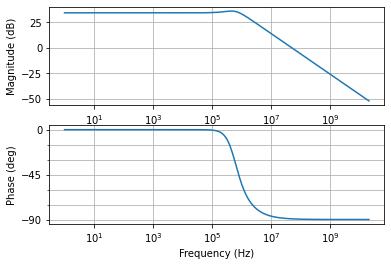

In [12]:
# the overall closed loop
Bs=(Ts*N)/((1+(Ts)))
(mag_FB, phase_rad_FB, w) = control.bode_plot(Bs, w,dB=True, Hz=True,deg= True )


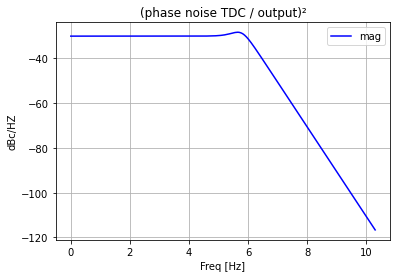

In [13]:
# TDC transfer specturm
T_out_TDC= Bs*(2*pi*delta/Tref)
#T_out_TDC=T_out_TDC/(1+(T_out_TDC/(N*(2*pi*delta/Tref))))
(mag_out_TDC, phase_out_TDC, w) = control.bode_plot(T_out_TDC, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_TDC)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('(phase noise TDC / output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

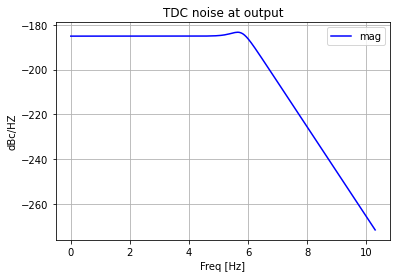

In [14]:
TDC_noise_output=T_TDC*((mag_out_TDC)**2)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(TDC_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('TDC noise at output')
plt.grid() 
plt.legend(labels=('mag',))

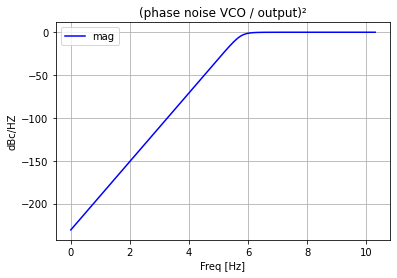

In [15]:
#Transfer function of different blocks 
#Transfer function of VCO phase output to phase of VCO
T_out_VCO=1/((1+(Ts)))
(mag_out_VCO, phase_out_VCO, w) = control.bode_plot(T_out_VCO, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_VCO)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('(phase noise VCO / output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

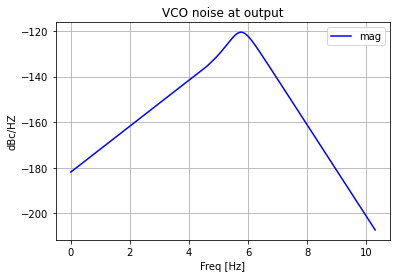

In [16]:
VCO_noise_output=mag*((mag_out_VCO)**2)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(VCO_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('VCO noise at output')
plt.grid() 
plt.legend(labels=('mag',))

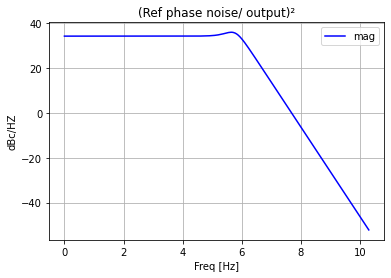

In [17]:
#Transfer function of different blocks 
#Transfer function of CP phase output to phase of Reference
T_out_ref=Bs
(mag_out_ref, phase_out_ref, w) = control.bode_plot(T_out_ref, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_ref)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('(Ref phase noise/ output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

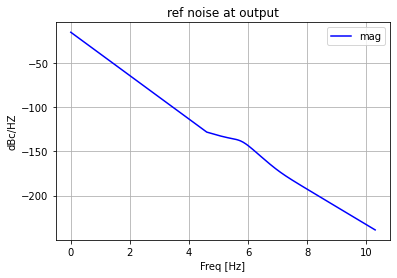

In [18]:
ref_noise_output=mag_ref*((mag_out_ref)**2)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(ref_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('ref noise at output')
plt.grid() 
plt.legend(labels=('mag',))

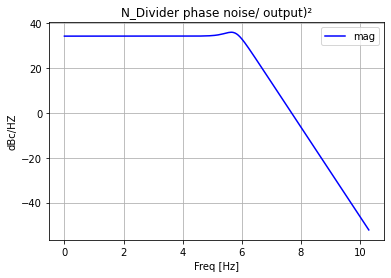

In [19]:
#Transfer function of N_Divider phase output to phase of Reference

T_out_N_Divider=Bs
(mag_out_N_Divider, phase_out_N_Divider, w) = control.bode_plot(T_out_N_Divider, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_N_Divider)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('N_Divider phase noise/ output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

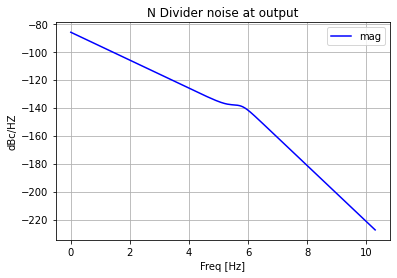

In [20]:
N_divider_noise_output=((mag_out_N_Divider)**2)*mag_Divider
plt.plot(np.log10(w/(2*pi)), 10*np.log10(N_divider_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('N Divider noise at output')
plt.grid() 
plt.legend(labels=('mag',))

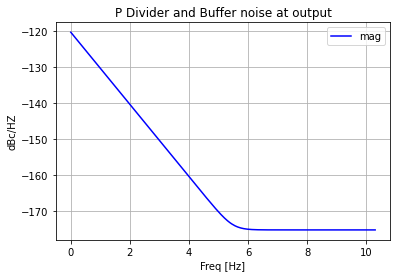

In [21]:

plt.plot(np.log10(w/(2*pi)), 10*np.log10(mag_Divider), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('P Divider and Buffer noise at output')
plt.grid() 
plt.legend(labels=('mag',))

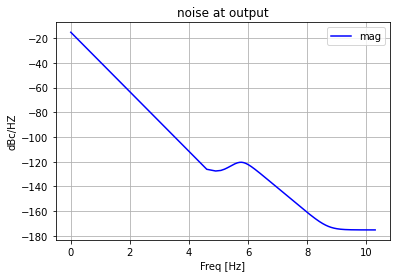

In [22]:
#calculation every noise at the output 
noise_output=VCO_noise_output+ref_noise_output+N_divider_noise_output+(mag_Divider)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('noise at output')
plt.grid() 
plt.legend(labels=('mag',))

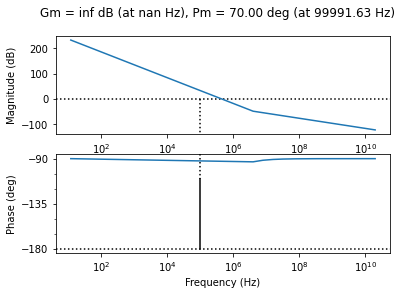

In [23]:
#outer loop integration
## transfer function
A2=0.0000098394218368793049896592713276916
B2=-0.000000090750722385970033965597674675025
DLF_2=control.tf([Tref*A2,B2],[Tref,0])
Outer_open_loop_gain=Ts*N*(DLF_2)*(Tref/(2*pi*delta*N))
wnew=np.linspace(2*pi*12e0,2*pi*20e9,5000)
(mag_outer, phase_rad_outer, wnew) = control.bode_plot(Outer_open_loop_gain, wnew,dB=True, deg= True ,Hz=True, margins=True)

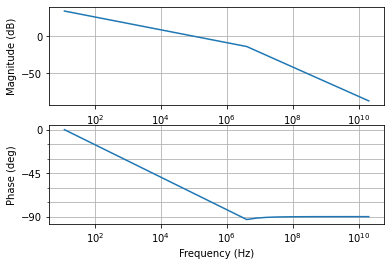

In [24]:
#low jitter with feed back 
closed_loop_outer_loop=(Outer_open_loop_gain*N)/(1+Outer_open_loop_gain)
(mag_outer, phase_rad_outer, wnew) = control.bode_plot(closed_loop_outer_loop, wnew,dB=True, deg= True ,Hz=True)

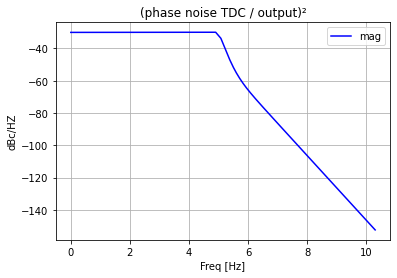

In [25]:
# TDC transfer specturm
T_out_TDC_2= closed_loop_outer_loop*(2*pi*delta/Tref)
#T_out_TDC=T_out_TDC/(1+(T_out_TDC/(N*(2*pi*delta/Tref))))
(mag_out_TDC_2, phase_out_TDC, w) = control.bode_plot(T_out_TDC_2, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_TDC_2)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('(phase noise TDC / output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

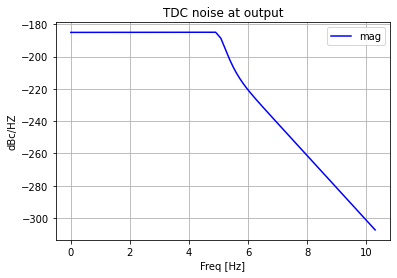

In [26]:
#noise sources TDC
TDC_2_noise_output=T_TDC*((mag_out_TDC_2)**2)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(TDC_2_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('TDC noise at output')
plt.grid() 
plt.legend(labels=('mag',))

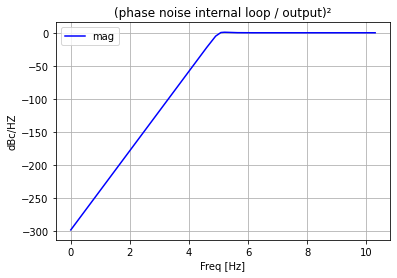

In [27]:
# noise of internal with low jitter attenuator as whole 
T_out_internal_loop=1/((1+(Outer_open_loop_gain)))
(mag_out_internal_loop, phase_out_internal_loop, w) = control.bode_plot(T_out_internal_loop, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_internal_loop)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('(phase noise internal loop / output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

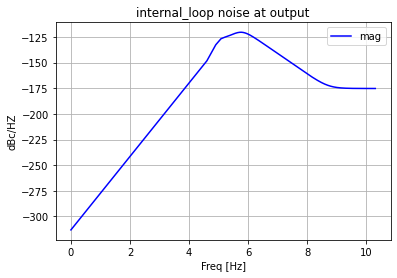

In [28]:
internal_loop_noise_output=noise_output*((mag_out_internal_loop)**2)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(internal_loop_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('internal_loop noise at output')
plt.grid() 
plt.legend(labels=('mag',))

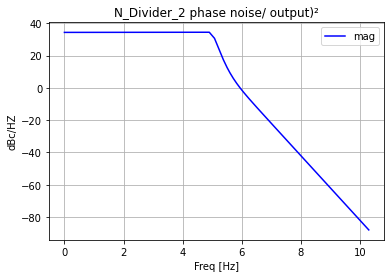

In [29]:
#Transfer function of N_Divider phase output to phase of Reference in outer loop of low jitter attenuator
T_out_N_Divider_2=closed_loop_outer_loop
(mag_out_N_Divider_2, phase_out_N_Divider, w) = control.bode_plot(T_out_N_Divider_2, w,dB=True, deg= True,plot=False)
plt.plot(np.log10(w/(2*pi)), 10*np.log10((mag_out_N_Divider_2)**2), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('N_Divider_2 phase noise/ output)\u00b2')
plt.grid() 
plt.legend(labels=('mag',))

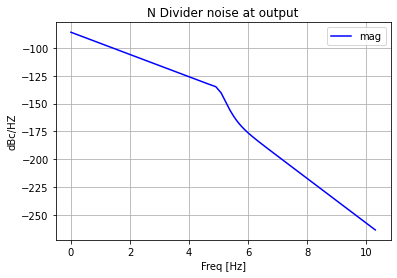

In [30]:
N_divider_2_noise_output=((mag_out_N_Divider_2)**2)*mag_Divider
plt.plot(np.log10(w/(2*pi)), 10*np.log10(N_divider_2_noise_output), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('N Divider noise at output')
plt.grid() 
plt.legend(labels=('mag',))

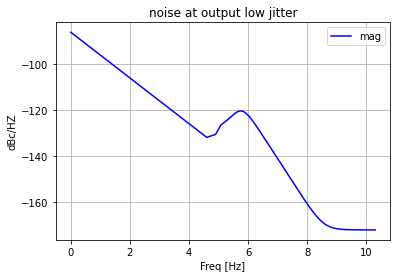

In [31]:
#calculation every noise at the output 
noise_output_low_jitter=N_divider_2_noise_output+internal_loop_noise_output+TDC_2_noise_output+(mag_Divider)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(noise_output_low_jitter), 'blue') 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('noise at output low jitter')
plt.grid() 
plt.legend(labels=('mag',))

In [32]:
Ts

TransferFunction(array([1.93216551e-03, 4.41865466e+03]), array([3.27249235e-10, 0.00000000e+00, 0.00000000e+00]))

In [33]:
DLF_2

TransferFunction(array([ 1.02493977e-13, -9.07507224e-08]), array([1.04166667e-08, 0.00000000e+00]))

In [34]:
Outer_open_loop_gain

TransferFunction(array([ 3.28315639e-13,  4.60123698e-07, -6.64796999e-01]), array([3.4088462e-18, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]))

### comparison (only notes)
noise_output=VCO_noise_output+CP_noise_output+ref_noise_output+loop_filter_noise_output+R_divider_noise_output+N_divider_noise_output+(2*mag_Divider)
noise_output_comp=CP_noise_output+ref_noise_output+R_divider_noise_output+N_divider_noise_output+(2*mag_Divider)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(noise_output), 'blue') 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(VCO_noise_output), 'red')
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('noise at output')
plt.grid() 
plt.legend(labels=('Total','mag_VCO','Close-in','loop_filter',))

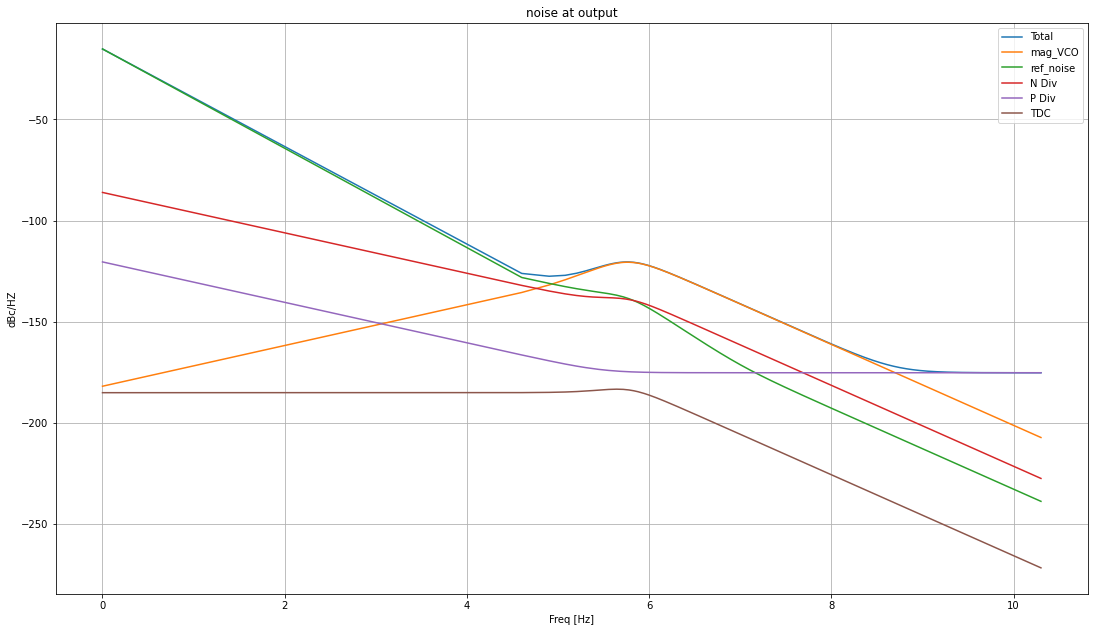

In [35]:
#comparison
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)
noise_output=VCO_noise_output+ref_noise_output+N_divider_noise_output+(mag_Divider)+TDC_noise_output
noise_output_comp=ref_noise_output+N_divider_noise_output+(mag_Divider)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(noise_output)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(VCO_noise_output))
# plt.plot(np.log10(w/(2*pi)), 10*np.log10(noise_output_comp))  
plt.plot(np.log10(w/(2*pi)), 10*np.log10(ref_noise_output))  
plt.plot(np.log10(w/(2*pi)), 10*np.log10(N_divider_noise_output)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(mag_Divider)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(TDC_noise_output))
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('noise at output')
plt.grid() 
plt.legend(labels=('Total','mag_VCO','ref_noise','N Div','P Div','TDC'))

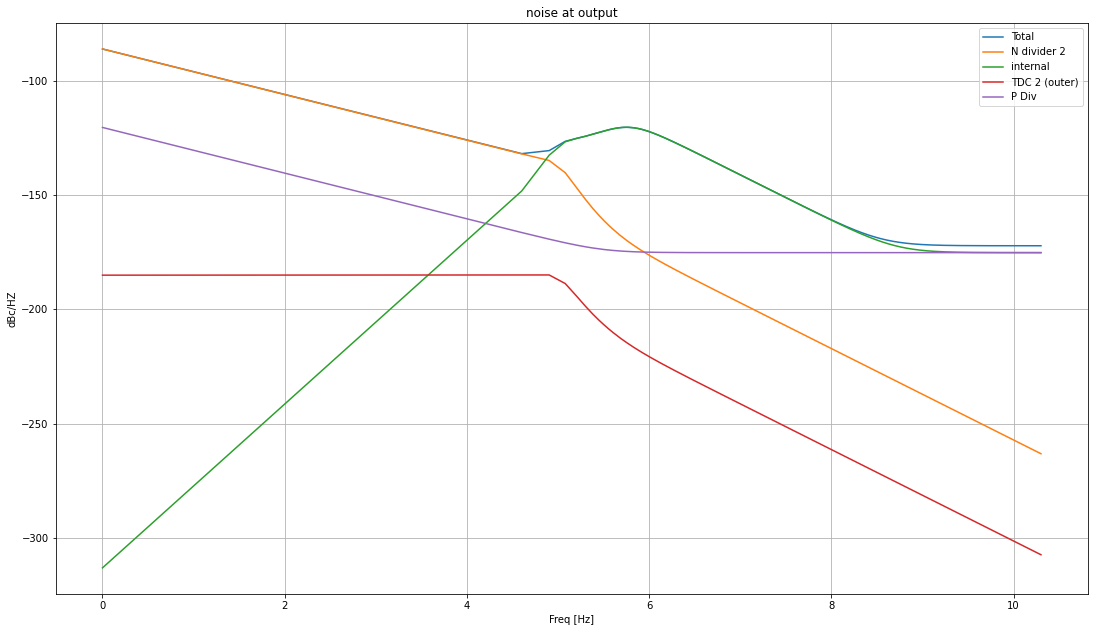

In [36]:
#comparison
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('test2png.png', dpi=100)
noise_output_low_jitter=N_divider_2_noise_output+internal_loop_noise_output+TDC_2_noise_output+(mag_Divider)
plt.plot(np.log10(w/(2*pi)), 10*np.log10(noise_output_low_jitter)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(N_divider_2_noise_output))
# plt.plot(np.log10(w/(2*pi)), 10*np.log10(noise_output_comp))  
plt.plot(np.log10(w/(2*pi)), 10*np.log10(internal_loop_noise_output))  
plt.plot(np.log10(w/(2*pi)), 10*np.log10(TDC_2_noise_output)) 
plt.plot(np.log10(w/(2*pi)), 10*np.log10(mag_Divider)) 
plt.xlabel('Freq [Hz]') 
plt.ylabel('dBc/HZ') 
plt.title('noise at output')
plt.grid() 
plt.legend(labels=('Total','N divider 2','internal','TDC 2 (outer)','P Div'))

In [40]:
jitter= np.trapz(noise_output_low_jitter, x=w/(2*pi))
jitter=jitter*2
jitter=(math.sqrt(jitter))/(2*pi*Fo)
jitter*1e15

51.58050918187341

In [43]:
# to calculate contribution of eact block 
def jitter(y):
    w=np.linspace(2*pi*12e3,2*pi*20e6,500000)
    jitter= np.trapz(y, x=w/(2*pi))
    jitter=jitter*2
    #jitter=(math.sqrt(jitter))/(2*pi*560e6)
    return(jitter*1e15)

In [44]:
(jitter(N_divider_2_noise_output)/jitter(noise_output_low_jitter))*100

0.4473540409570255

In [45]:
jitter(internal_loop_noise_output)/(jitter(noise_output_low_jitter))*100

99.54785025490415

In [46]:
(jitter(TDC_2_noise_output)/jitter(noise_output_low_jitter))*100

2.751317535035719e-06

In [47]:
(jitter(mag_Divider)/jitter(noise_output_low_jitter))*100

0.004792952821322764